In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import statsmodels.api as sm

In [3]:
## code from github, link  https://github.com/talhahascelik/python_stepwiseSelection/blob/master/stepwiseSelection.py

#Copyright 2019 Sinan Talha Hascelik
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.


def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)
    
def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Backward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression    
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):
    
    iterations_log = ""
    last_eleminated = ""    
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :          
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break   
            else: 
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break
    print(str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic))
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log

In [4]:
Data=pd.read_csv(r'C:\Users\lenovo\Desktop\506\project 506\Data1.csv')

In [5]:
Data=Data.drop(['SEQN'],axis=1)#drop the id variable 'SEQN' 

In [6]:
RACE=pd.get_dummies(Data['RACE'])# python seems has no factor way, so using this way to modify factors.
RACENAME=['Mexican American','Other Hispanic','Non-Hispanic White','Non-Hispanic Black','Non-Hispanic Asian','Other Race']
RACE.columns=[ i for i in RACENAME]
RACE=RACE.drop(['Mexican American'],axis=1)# drop first category as base

GENDER=pd.get_dummies(Data['GENDER'])
gendername=['Male','Female']
GENDER.columns=[i for i in gendername]
GENDER=GENDER.drop(['Male'],axis=1)

Data=Data.drop(['GENDER','RACE'],axis=1)
Data=pd.concat([Data,GENDER,RACE],axis=1)

In [7]:
y1=Data[['LBDLDL']] ## lm reg, the response= LBDLDL (LDL)
x1=Data.drop(['LBDLDL'],axis=1) # others except LDL are the variables
x1=sm.add_constant(x1)     ## add intercept, for python, add 1 colunms by hand

lm1=sm.OLS(y1.astype(float),x1.astype(float)).fit() # OLS y on X+1

In [8]:
lm1.summary()     # coefficient table

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LBDLDL   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     25.69
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           2.47e-67
Time:                        21:58:32   Log-Likelihood:                -12321.
No. Observations:                2503   AIC:                         2.467e+04
Df Residuals:                    2487   BIC:                         2.477e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                101.5715     44.874      2.263      0.024      13.576     189.566
LBXTR                  0.1428      0.011     12.546      0.000       0.120       0.165
BPXSY                 -0.0059      0.046     -0.129      0.898      -0.096       0.084
BPXDI                  0.4018      0.057      6.994      0.000       0.289       0.514
FAT                    0.0053      0.023      0.233      0.816      -0.039       0.050
CHOL                  -0.0013      0.004     -0.288      0.774      -0.010       0.007
AGE                    0.1758      0.039      4.544      0.000       0.100       0.252
HEIGHT                -0.3181      0.270     -1.180      0.238      -0.847       0.211
WEIGHT                 0.3017      0.266      1.133      0.257      -0.220       0.824
BMI                   -0.5955      0.741     -0.803      0.422      -2.049       0.858
Female                 1.1712      1.848      0.634      0.526      -2.452       4.794
Other Hispanic         3.9526      2.414      1.637      0.102      -0.781       8.687
Non-Hispanic White     2.0370      2.094      0.973      0.331      -2.069       6.143
Non-Hispanic Black     3.5060      2.286      1.534      0.125      -0.977       7.989
Non-Hispanic Asian     5.1046      2.738      1.864      0.062      -0.265      10.474
Other Race             6.0369      3.880      1.556      0.120      -1.572      13.646
==============================================================================
Omnibus:                      121.293   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.325
Skew:                           0.469   Prob(JB):                     9.30e-36
Kurtosis:                       3.816   Cond. No.                     2.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### From result, many coefficient are not significant, so to better select variables, we are going to see the resdisual condition and use boxcox to help .

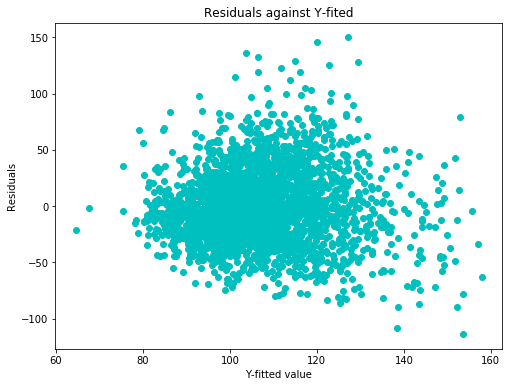

In [9]:
#plot residual vesus y-fitted fig
res1=lm1.resid
y1_fit=lm1.predict(x1)
fig1=plt.figure(figsize=(8,6))
plt.plot(y1_fit,res1,'o''c') #'0' means dots,''''means no line between dots, 'c' color
plt.title('Residuals against Y-fited')
plt.ylabel('Residuals')
plt.xlabel('Y-fitted value')
plt.show()

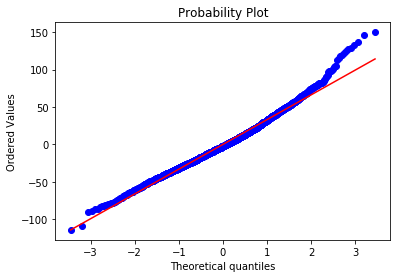

In [10]:
#plot QQplot fig
res = lm1.resid  # residuals
stats.probplot(res, dist="norm", plot=pylab) # QQplot, simliar to fig = sm.qqplot(res)
pylab.show()

### First, we plot y_fit versus residual, then we plot QQplot of residual, and we can see that the QQplot shows that the residual is not really normal

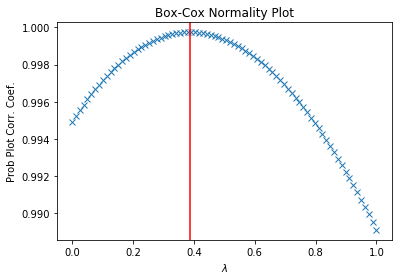

In [11]:
#boxcox
y2=np.array(y1).flatten() #transform pandas columns to list(like vector in R)
#plot boxcox
fig2=plt.figure()
ax = fig2.add_subplot(111)
prob=stats.boxcox_normplot(y2,0,1,plot=ax) #at range(0,1)
_, maxlog=stats.boxcox(y2)
ax.axvline(maxlog,color='r')#best value of lambda
plt.show()

### From the plot, we can tansform the y value to y**(lambda), when lambda is around 0.4, then result seems best,to make it simple we pick lambda=0.5

In [12]:
Data['LDL']=(Data[['LBDLDL']])**0.5 # transform the y value to y**0.5 as picked above
Data=Data.drop(['LBDLDL'],axis=1) 

In [13]:
y3=Data[['LDL']]
#select model
x3=Data.drop(['LDL'],axis=1) 
final_vars,_=forwardSelection(x3,y3,model_type='linear',elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Entered : LBXTR 	AIC : 9574.218891776083
Entered : BPXDI 	AIC : 9503.117731043025
Entered : AGE 	AIC : 9475.727581279705
Entered : BMI 	AIC : 9470.123755541823
Break : Significance Level
                            OLS Regression Results                            
Dep. Variable:                    LDL   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     93.04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           7.62e-74
Time:                        21:58:37   Log-Likelihood:                -4730.1
No. Observations:                2503   AIC:                             9470.
Df Residuals:                    2498   BIC:                             9499.
Df Model:                           4                                         
Covariance Type:            nonrobu

In [14]:
final_vars,_=backwardSelection(x3,y3,model_type='linear',elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : BPXSY
Eliminated : FAT
Eliminated : CHOL
Eliminated : Female
Eliminated : BMI
Eliminated : Non-Hispanic White
Eliminated : Non-Hispanic Black
Eliminated : Other Hispanic
Eliminated : Other Race
Eliminated : Non-Hispanic Asian
                            OLS Regression Results                            
Dep. Variable:                    LDL   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     74.87
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           2.88e-73
Time:                        21:58:39   Log-Likelihood:                -4729.0
No. Observations:                2503   AIC:                             9470.
Df Residuals:                    2497   BIC:                             9505.
Df Model:                           5                         

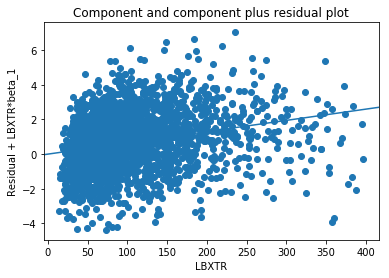

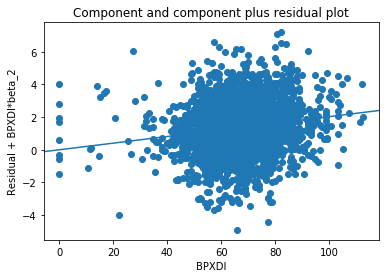

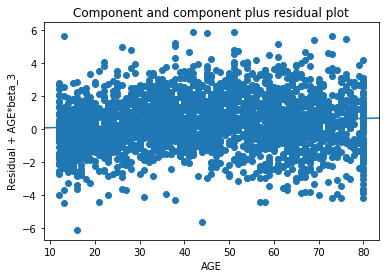

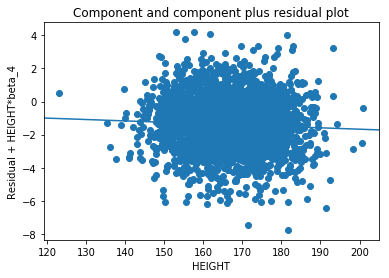

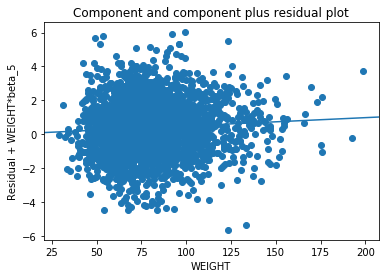

In [15]:
x4=Data[['LBXTR', 'BPXDI', 'AGE', 'HEIGHT', 'WEIGHT']] #select colsnames
x4=sm.add_constant(x4)
#plot ppcr vesus these variables
lm2=sm.OLS(y3.astype(float),x4.astype(float)).fit()
for i in range(5):
    name=x4.columns[i+1]
    sm.graphics.plot_ccpr(lm2,name) # https://en.wikipedia.org/wiki/Partial_residual_plot  
    #The CCPR (component and component-plus-residual) plot is a refinement of the partial residual plot
plt.show()

### From the graphes above, we can see that LBXTR and AGE plots, there are a little inverse 'U' shape, so in the final model, we add LBXTR square and AGE square terms.

In [16]:
#add columns
Data['AGE2']=Data[['AGE']]*Data[['AGE']]
Data['LBXTR2']=Data[['LBXTR']]*Data[['LBXTR']]
y5=Data[['LDL']]
x5=Data.drop(['LDL'],axis=1)

In [17]:
#reselect models
final_vars,_=forwardSelection(x5,y5,model_type='linear',elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Entered : LBXTR 	AIC : 9574.218891776083
Entered : LBXTR2 	AIC : 9448.966446031709
Entered : BPXDI 	AIC : 9384.22136728393
Entered : AGE 	AIC : 9373.946948986257
Entered : AGE2 	AIC : 9246.164944091768
Break : Significance Level
                            OLS Regression Results                            
Dep. Variable:                    LDL   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     128.6
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          1.75e-121
Time:                        21:58:42   Log-Likelihood:                -4617.1
No. Observations:                2503   AIC:                             9246.
Df Residuals:                    2497   BIC:                             9281.
Df Model:                           5                                   

In [18]:
final_vars,_=backwardSelection(x5,y5,model_type='linear',elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : FAT
Eliminated : Other Hispanic
Eliminated : Non-Hispanic Asian
Eliminated : Female
Eliminated : CHOL
Eliminated : Non-Hispanic White
Regained :  Non-Hispanic White
                            OLS Regression Results                            
Dep. Variable:                    LDL   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     55.30
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          1.87e-118
Time:                        21:58:43   Log-Likelihood:                -4608.2
No. Observations:                2503   AIC:                             9242.
Df Residuals:                    2490   BIC:                             9318.
Df Model:                          12                                         
Covariance Type:            nonrobust       

### From AIC comparison, we select variables 'LBXTR', 'BPXSY', 'BPXDI', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI', 'RACE', 'AGE2', 'LBXTR2'

In [19]:
y=Data[['LDL']]
x=Data[['LBXTR', 'BPXSY', 'BPXDI', 'AGE', 'HEIGHT', 'WEIGHT', 'BMI','Other Hispanic','Non-Hispanic White','Non-Hispanic Black','Non-Hispanic Asian','Other Race', 'AGE2', 'LBXTR2']]
#here we add all RACE types except RACE='Mexican American', which is viewed as base
x=sm.add_constant(x)
lm_final=sm.OLS(y.astype(float),x.astype(float)).fit()
lm_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LDL   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     47.49
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          5.38e-117
Time:                        21:58:44   Log-Likelihood:                -4607.5
No. Observations:                2503   AIC:                             9245.
Df Residuals:                    2488   BIC:                             9332.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.1998      2.017      5.552      0.000       7.244      15.155
LBXTR                  0.0216      0.002     13.012      0.000       0.018       0.025
BPXSY                  0.0041      0.002      1.922      0.055   -8.27e-05       0.008
BPXDI                  0.0063      0.003      2.212      0.027       0.001       0.012
AGE                    0.1057      0.009     12.245      0.000       0.089       0.123
HEIGHT                -0.0329      0.012     -2.700      0.007      -0.057      -0.009
WEIGHT                 0.0256      0.012      2.100      0.036       0.002       0.050
BMI                   -0.0732      0.034     -2.150      0.032      -0.140      -0.006
Other Hispanic         0.0896      0.111      0.810      0.418      -0.127       0.307
Non-Hispanic White     0.1879      0.094      1.997      0.046       0.003       0.372
Non-Hispanic Black     0.2247      0.103      2.175      0.030       0.022       0.427
Non-Hispanic Asian     0.1355      0.125      1.081      0.280      -0.110       0.381
Other Race             0.3472      0.177      1.966      0.049       0.001       0.694
AGE2                  -0.0011   9.46e-05    -11.824      0.000      -0.001      -0.001
LBXTR2             -5.029e-05      5e-06    -10.053      0.000   -6.01e-05   -4.05e-05
==============================================================================
Omnibus:                        7.784   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                9.359
Skew:                          -0.038   Prob(JB):                      0.00928
Kurtosis:                       3.290   Cond. No.                     1.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# additional analysis
#quantile regression sqrt(LBDLDL)~AGE
mod=smf.quantreg('LDL~AGE',Data) 
quantiles = np.arange(.05, .95, .1)
def fit_model(q):       
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['AGE']] + \
            res.conf_int().loc['AGE'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lower_b', 'upper_b'])#refers to quantile interception slope CI_of_slope

ols = smf.ols('LDL ~ AGE', Data).fit() #normal reg
ols_ci = ols.conf_int().loc['AGE'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['AGE'],
           lower_b = ols_ci[0],  # Ci for b,lowerbound
           upper_b = ols_ci[1])  #CI for b, upbound

print(models)
print(ols)

      q          a         b   lower_b   upper_b
0  0.05   7.365460  0.003383 -0.004561  0.011326
1  0.15   8.134052  0.008011  0.003168  0.012855
2  0.25   8.476658  0.013114  0.008268  0.017960
3  0.35   8.848354  0.016674  0.012116  0.021231
4  0.45   9.222907  0.017595  0.013548  0.021642
5  0.55   9.687246  0.016327  0.012471  0.020183
6  0.65   9.993639  0.019470  0.015664  0.023275
7  0.75  10.422162  0.020762  0.016958  0.024566
8  0.85  11.041352  0.020834  0.016755  0.024912
{'a': 9.590565977646857, 'b': 0.014434702126817942, 'lower_b': 0.011225620121011557, 'upper_b': 0.017643784132624327}


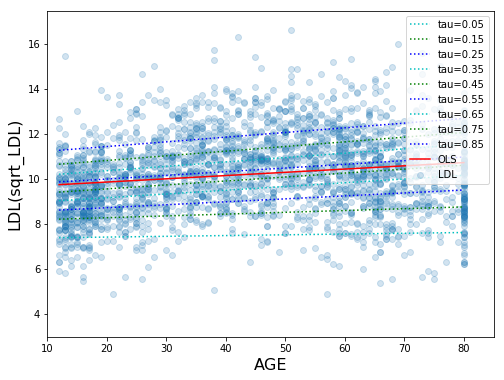

In [32]:
#plot all the quantile line by line in a fig
x = np.arange(Data.AGE.min(), Data.AGE.max()+1, 1)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))
#tau=0.05-0.95
y = get_y(models.a[0], models.b[0])
ax.plot(x, y, linestyle='dotted', color='c',label='tau=0.05')
y = get_y(models.a[1], models.b[1])
ax.plot(x, y, linestyle='dotted', color='g',label='tau=0.15')
y = get_y(models.a[2], models.b[2])
ax.plot(x, y, linestyle='dotted', color='b',label='tau=0.25')
y = get_y(models.a[3], models.b[3])
ax.plot(x, y, linestyle='dotted', color='c',label='tau=0.35')
y = get_y(models.a[4], models.b[4])
ax.plot(x, y, linestyle='dotted', color='g',label='tau=0.45')
y = get_y(models.a[5], models.b[5])
ax.plot(x, y, linestyle='dotted', color='b',label='tau=0.55')
y = get_y(models.a[6], models.b[6])
ax.plot(x, y, linestyle='dotted', color='c',label='tau=0.65')
y = get_y(models.a[7], models.b[7])
ax.plot(x, y, linestyle='dotted', color='g',label='tau=0.75')
y = get_y(models.a[8], models.b[8])
ax.plot(x, y, linestyle='dotted', color='b',label='tau=0.85')


y = get_y(ols['a'], ols['b'])
ax.plot(x, y, color='red', label='OLS')
ax.scatter(Data.AGE, Data.LDL, alpha=.2)
ax.set_xlim((10, 85))
ax.set_ylim((3.0, 17.5))
legend = ax.legend()
ax.set_xlabel('AGE', fontsize=16)
ax.set_ylabel('LDL(sqrt_LDL)', fontsize=16);